In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 'large',
    'figure.dpi': 100,
})

In [2]:
# Import all measurements from the `./measurements` directory. Each measurement file
# is read into a numpy array (column-first) and added to the `meas_dict` (keys are
# filenames with extentions removed).
meas_dir = os.fsencode('./measurements')
meas_dict = {}
for fname in os.listdir(meas_dir):
    with open(os.path.join(meas_dir, fname)) as file:
        meas = [[float(el) for el in row.rstrip().split(',')]
                for row in file.readlines()]
        meas_name = os.fsdecode(fname).removesuffix('.csv')
        meas_dict[meas_name] = np.array(meas).T

In [3]:
μ_0 = 1.257e-6

# Integrator characteristic R and C.
R, ΔR = 10e3, 0.5e3
C, ΔC = 1e-6, 0.1e-6

In [4]:
# Measurement coil a.
N_a = 2000
r_1, Δr_1 = 18e-3/2, 0.1e-3/2
r_2, Δr_2 = 23e-3/2, 0.5e-3/2

# Big ring coil -- coil A.
N_A = 200
r_A = 250e-3/2
d_A = 2.4e-2 # Coil A's thickness.

# Measurement a, A.
I_A = 4.401
h, U_a, ΔU_a = meas_dict['big-coil']
h, U_a, ΔU_a = 1e-2 * h + d_A/2, 1e-3 * U_a, 1e-3 * ΔU_a

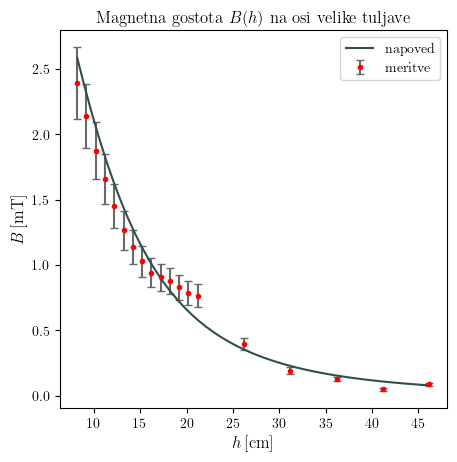

In [5]:
# Calculate B_A from integrated U_a.
B_A = U_a * 2*R*C / (N_a*np.pi * (r_1**2 + r_2**2))
ΔB_A = np.sqrt(
    (1 * 2*R*C / (N_a*np.pi * (r_1**2 + r_2**2)) * ΔU_a)**2 +
    (U_a * 2*1*C / (N_a*np.pi * (r_1**2 + r_2**2)) * ΔR)**2 +
    (U_a * 2*R*1 / (N_a*np.pi * (r_1**2 + r_2**2)) * ΔC)**2 +
    (-U_a * 2*R*C / (N_a*np.pi * (r_1**2 + r_2**2)**2) * 2*r_1 * Δr_1)**2 +
    (-U_a * 2*R*C / (N_a*np.pi * (r_1**2 + r_2**2)**2) * 2*r_2 * Δr_2)**2
)

# Plot.
fig, ax = plt.subplots(1, 1, figsize=[5, 5])

# B_A measurements and predicted curve.
ax.errorbar(1e2 * h, 1e3 * B_A, yerr=(1e3 * ΔB_A),
            fmt='.', color='red', ecolor='dimgray', capsize=3, label='meritve')
h_lin = np.linspace(np.min(h), np.max(h))
B_A_predicted = N_A*μ_0*I_A * r_A**2 / (2 * (r_A**2 + h_lin**2)**(3/2))
ax.plot(1e2 * h_lin, 1e3 * B_A_predicted, color='darkslategrey', linestyle='-', label='napoved')

# Labels and style.
ax.set_title('Magnetna gostota $B(h)$ na osi velike tuljave')
ax.set_xlabel(r'$h\,[\mathrm{cm}]$')
ax.set_ylabel(r'$B\,[\mathrm{mT}]$')
ax.legend()
fig.savefig('big-coil.pdf')

In [6]:
# Measurement coil b.
N_b = 200
r_1, Δr_1 = 18e-3/2, 0.1e-3/2
r_2, Δr_2 = 23e-3/2, 0.5e-3/2

# Measurement b, B.
I, U_b, ΔU_b = meas_dict['slit']
I, U_b, ΔU_b = I, U_b, 1e-3 * ΔU_b

(0.138236966243347,
 0.007664249131388017,
 109973.72016177168,
 6097.254678908526)

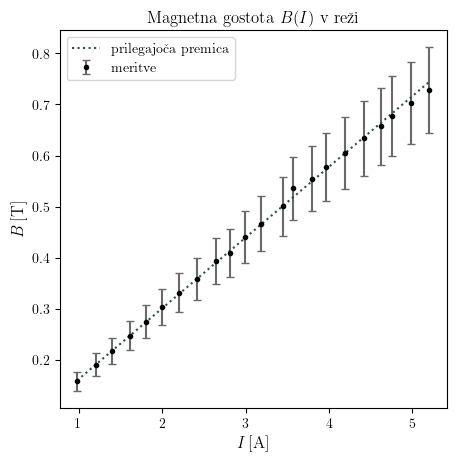

In [10]:
# Calculate B_B from integrated U_b.
B_B = U_b * 2*R*C / (N_b*np.pi * (r_1**2 + r_2**2))
ΔB_B = np.sqrt(
    (1 * 2*R*C / (N_b*np.pi * (r_1**2 + r_2**2)) * ΔU_b)**2 +
    (U_b * 2*1*C / (N_b*np.pi * (r_1**2 + r_2**2)) * ΔR)**2 +
    (U_b * 2*R*1 / (N_b*np.pi * (r_1**2 + r_2**2)) * ΔC)**2 +
    (-U_b * 2*R*C / (N_b*np.pi * (r_1**2 + r_2**2)**2) * 2*r_1 * Δr_1)**2 +
    (-U_b * 2*R*C / (N_b*np.pi * (r_1**2 + r_2**2)**2) * 2*r_2 * Δr_2)**2
)

def linear(x, k, c):
    return k*x + c

# Fit a line through measurements.
par, cov = curve_fit(
    linear, I, B_B, sigma=ΔB_B, absolute_sigma=True)
k, c = par
σ_k, σ_c = np.sqrt(np.diag(cov))

# Plot.
fig, ax = plt.subplots(1, 1, figsize=[5, 5])

# B_A measurements and predicted curve.
ax.errorbar(I, B_B, yerr=ΔB_B,
            fmt='.', color='black', ecolor='dimgray', capsize=3, label='meritve')
I_lin = np.linspace(np.min(I), np.max(I))
ax.plot(I_lin, k*I_lin + c, color='darkslategrey', linestyle=':', label='prilegajoča premica')

# Labels and style.
ax.set_title('Magnetna gostota $B(I)$ v reži')
ax.set_xlabel(r'$I\,[\mathrm{A}]$')
ax.set_ylabel(r'$B\,[\mathrm{T}]$')
ax.legend()
fig.savefig('slit.pdf')
k, σ_k, k/μ_0, σ_k/μ_0